In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_by_day
from scipy.optimize import linprog
from datetime import datetime
from datetime import timedelta as dt_timedelta

from optimal_design import SinglePeriodModel, MultiPeriodModel
from peak_id import gamma_matrix, timedelta, identify_worst_days, assert_int


ValueError: attempted relative import beyond top-level package

In [3]:
time, load, solar_pu = load_by_day(0, 366)
time = time / 60
dt = timedelta(time)

NameError: name 'timedelta' is not defined

In [3]:
worst_load, worst_solar_pu = identify_worst_days(time, load, solar_pu)

In [4]:
print(list(worst_load.keys()))

['low_load_low_solar', 'medium_load_low_solar', 'medium_load_medium_solar', 'high_load_cloudy', 'high_load_sunny']


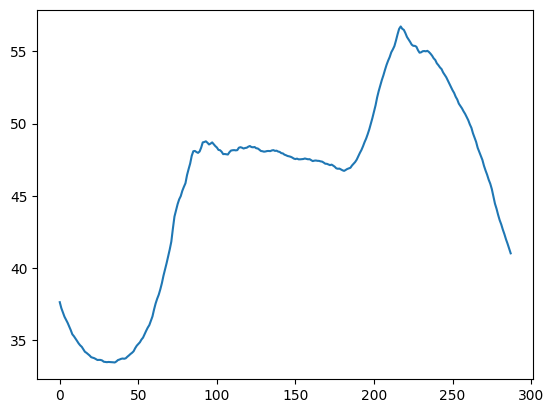

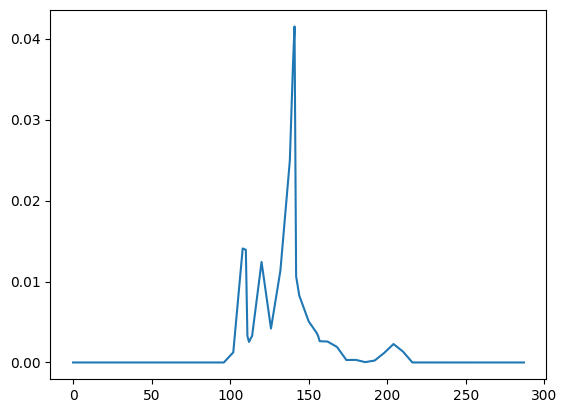

In [5]:
scenario = 'low_load_low_solar'
time_hr = time / 60
plt.plot(worst_load[scenario])
plt.figure()
plt.plot(worst_solar_pu[scenario])

In [51]:
# STATUS_MESSAGES = {
#     0 : "Optimization terminated successfully.",
#     1 : "Iteration limit reached.",
#     2 : "Problem appears to be infeasible.",
#     3 : "Problem appears to be unbounded.",
#     4 : "Numerical difficulties encountered."
# }

# class MultiPeriodResult:
#     def __init__(self, result, model, dt, scenarios, num_generation, C, b0):
#         if not result.success:
#             raise RuntimeError(f"Linear program failed with status code {result.status}:\n"
#                                f"{STATUS_MESSAGES[result.status]}")
        
#         self.result = result
#         self.model = model
#         self.scenarios = scenarios
#         self.E_max = result.x[-3]
#         self.P_solar = result.x[-2]
#         self.P_battery = result.x[-1]
#         self.dt = dt
#         self.num_timesteps = assert_int((result.x.shape[0] - num_generation - 2) / len(scenarios))
#         self.u_batt = {
#             name: self.battery_control(k)
#             for k, name in enumerate(scenarios)
#         }
#         self.x = {
#             name: self.battery_charge(u_batt)
#             for name, u_batt in self.u_batt.items()
#         }
#         self.C = C
#         self.b0 = b0
#         self.num_generation = num_generation
        
#     def battery_control(self, k):
#         # Find the battery control for a given scenario
#         start = k * self.num_timesteps
#         end = (k + 1) * self.num_timesteps
#         return self.result.x[start:end]
        
#     def battery_charge(self, u_batt):
#         # Calculate state of charge based on the feasible
#         # u_batt control.
#         gamma = gamma_matrix(self.num_timesteps, dt)
#         x0 = self.model.eta * self.E_max
#         x = gamma @ u_batt + x0
#         return np.r_[x0, x[:-1]]
        
# class MultiPeriodModel:
#     def __init__(self, initial_battery_charge, depth_of_discharge,
#                  cost_battery_energy, cost_battery_power, cost_solar):
#         self.eta = initial_battery_charge
#         self.rho = depth_of_discharge
#         self.cost_battery_energy = cost_battery_energy
#         self.cost_battery_power = cost_battery_power
#         self.cost_solar = cost_solar
        
        
#     def minimize_cost(self, time, load, generation):
#         """Minimize cost over multiple periods, ensuring battery is full at EoD."""
#         T = time.shape[0]
#         dt = timedelta(time)
#         # Load (str -> array(T))
#         # Generation (str -> array(T, G))
#         scenarios = list(load.keys())
#         assert  set(scenarios) == set(generation.keys()), \
#             "Load and generation dictionaries must have same keys."
#         for l in load.values():
#             # 
#             assert l.shape[0] == T, "Each load profile must have same number of timesteps."
            
#         generation = generation.copy()
#         num_generation = None
#         for name, gen in generation.items():
#             assert gen.shape[0] == T, "Each generation profile must have same number of timesteps."
#             if gen.ndim == 1:
#                 generation[name] = gen[:, np.newaxis]
#             elif gen.ndim > 2:
#                 raise ValueError("Got generation profile with dimension >2.")
#             if num_generation is None:
#                 num_generation = generation[name].shape[1]
#             elif generation[name].shape[1] != num_generation:
#                 raise ValueError("Not all generation scenarios have the same number of generation sources!")
                
#         # Constraint sensitivity w.r.t. battery control
#         gamma = gamma_matrix(T, dt)
#         A = np.vstack([
#             gamma,
#             -gamma,
#             np.eye(T),
#             -np.eye(T),
#             np.eye(T),
#             -np.eye(T)
#         ])
        
#         zero = np.zeros(T)
#         one = np.ones(T)
        
#         # Constraint sensitivity w.r.t. design parameters
#         B_list = [
#             np.c_[
#                 np.r_[one * (1 - self.eta), one[:-1] * (self.eta - self.rho), 0,
#                       zero, zero, zero, zero],
#                 np.kron(np.array([0, 0, 0, 1, 0, 0])[:, np.newaxis], generation[k]),
#                 np.kron([0, 0, 0, 0, 1, 1], one)
#             ]
#             for k in scenarios
#         ]

        
#         # Full constraint matrix for concatenated decision variables [u_k, d]
#         C = np.c_[
#             np.kron(np.eye(len(scenarios)), A),
#             -np.vstack(B_list)
#         ]
#         # Constant constraints from load
#         b_list = [
#             np.kron([0, 0, 1, -1, 0, 0], load[k])
#             for k in scenarios
#         ]
#         b0 = np.concatenate(b_list)
#         # Costs associated with battery control (0) and system design
#         c = np.r_[np.zeros(T * len(scenarios)),
#                   self.cost_battery_energy,
#                   self.cost_solar,
#                  self.cost_battery_power]
        
        
#         return MultiPeriodResult(
#             linprog(c, A_ub=C, b_ub=b0, bounds=(None, None)),
#             self,
#             dt,
#             scenarios,
#             num_generation,
#             C, b0
#         )

In [52]:
time_one_day = time[:worst_load[scenario].shape[0]]
# Test single load.
# load = {
#     scenario: worst_load[scenario]
# }
# generation = {
#     scenario: worst_solar_pu[scenario]
#     'first': np.ones((time.shape)),
#     'second': 2 * np.ones((time.shape))
# }

In [53]:
model = MultiPeriodModel(
    initial_battery_charge=0.5,
    depth_of_discharge=0.1,
    cost_battery_energy=100,
    cost_battery_power=10,
    cost_solar=10)
res = model.minimize_cost(time_one_day, worst_load, worst_solar_pu)

In [31]:
def readable(s):
    # Replace underscores with spaces and capitalize each word.
    return " ".join(map(lambda word: word.capitalize(), s.split("_")))

In [77]:
def greedy_battery_control(result, load, generation):
    E_max = result.E_max
    x0 = E_max * result.model.eta
    P_max = result.P_battery
    E_min = E_max * result.model.rho
    # Various other controls are feasible and quite likely superior in terms
    # of limiting degradation. But this should give a better sense of how much
    # we are running up on the limits, than the control given by LP output?
    u_out = np.zeros_like(load)
    x_out = np.zeros_like(load)
    for i, (load_t, gen_t) in enumerate(zip(load, generation)):
        x_curr = x0 if i == 0 else x_out[i - 1]
        # Pull maximum amount of generation (infinite curtailment)
        u_curr = max(-P_max, load_t - gen_t)
        if u_curr > P_max:
            raise ValueError("Infeasible control: Load exceeds battery discharge limits.")
        x_next = x_curr - dt * u_curr
        if x_next < E_min:
            raise ValueError("Infeasible control: Out of battery capacity.")
        elif x_next > E_max:
            # Battery is full!
            x_next = E_max
            u_curr = (x_curr - E_max) / dt
        x_out[i] = x_next
        u_out[i] = u_curr
    return u_out, x_out
        
            
        
        

In [102]:
# Potentially interesting plots:
# Aggregated SoC at end of day (mean/std of each month) (of course, this depends on eta)
#     Include also minimum SoC
# SoC over day for the day in each month that reaches minimum battery capacity 
# Amount of renewable generation curtailment (to what degree is this a function of generation source?)

In [104]:
dt = timedelta(time)
timesteps_per_day = assert_int(24 / dt)

In [159]:
u_batt_year, soc_year = greedy_battery_control(res, load, solar_pu * res.P_solar)

In [160]:
u_batt_per_day = u_batt_year.reshape(-1, timesteps_per_day)
soc_per_day = soc_year.reshape(-1, timesteps_per_day)

In [124]:
MONTH_NAMES = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}
NAME_TO_MONTH_NUM = {
    name: num for num, name in MONTH_NAMES.items()
}

In [123]:
DAY_RANGES = {}
jan1 = datetime(2012, 1, 1)
for month in range(1, 13):
    start = datetime(2012, month, 1)
    if month != 12:
        end = datetime(2012, month + 1, 1)
    else:
        end = datetime(2013, 1, 1)
    DAY_RANGES[month] = (
        (start - jan1).days, 
        (end - jan1).days
    )

In [125]:
def day_range(month_name):
    return DAY_RANGES[NAME_TO_MONTH_NUM[month_name]]

In [132]:
generation = solar_pu * res.P_solar
generation_per_day = generation.reshape(-1, timesteps_per_day)
load_per_day = load.reshape(-1, timesteps_per_day)

In [192]:
curtailment = generation - load - u_batt_year

In [194]:
curtailment_by_day = curtailment.reshape(-1, timesteps_per_day)

In [168]:
def iter_months(data_per_day):
    for month in range(1, 13):
        start, end = DAY_RANGES[month]
        yield data_per_day[start:end]

In [196]:
res.P_solar / 1000

20.954493167705017

Text(0, 0.5, 'Energy curtailed (MWh/day)')

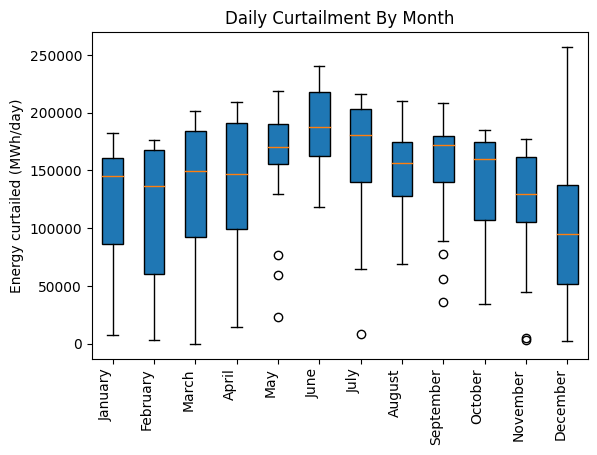

In [198]:
daily_curtailment = [np.sum(c, axis=1) * dt
                     for c in iter_months(curtailment_by_day)]
fig = plt.figure()
plt.boxplot(daily_curtailment, vert=True, patch_artist=True, labels=month_names)
fig.autofmt_xdate(rotation=90)
plt.title("Daily Curtailment By Month")
plt.ylabel("Energy curtailed (MWh/day)")



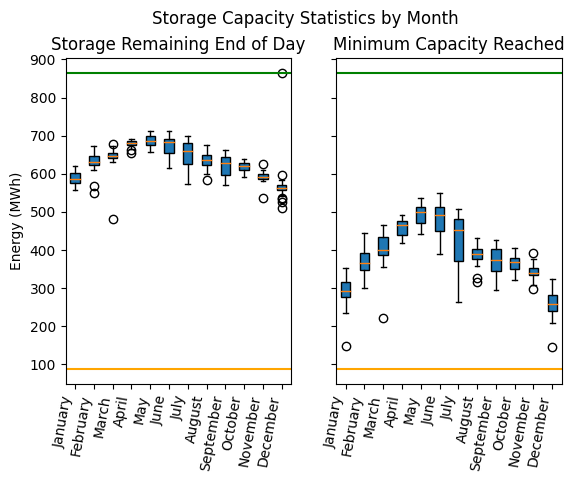

In [191]:
E_max = res.E_max
E_min = res.E_max * res.model.rho
eod_soc = [soc[:, -1] for soc in iter_months(soc_per_day)]
min_soc = [np.min(soc, axis=1) for soc in iter_months(soc_per_day)]
# max_soc = [np.max(soc, axis=1) for soc in iter_months(soc_per_day)]
month_names = [MONTH_NAMES[i] for i in range(1, 13)]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
plt.suptitle("Storage Capacity Statistics by Month")
ax1.boxplot(eod_soc, vert=True, patch_artist=True, labels=month_names)
ax1.set_title("Storage Remaining End of Day")
ax1.set_ylabel("Energy (MWh)")
ax2.boxplot(min_soc, vert=True, patch_artist=True, labels=month_names)
ax2.set_title("Minimum Capacity Reached")
# ax3.boxplot(max_soc, vert=True, patch_artist=True, labels=month_names)
# ax3.set_title("Maximum Capacity Reached")
# for ax in [ax1, ax2, ax3]:
for ax in [ax1, ax2]:
    ax.axhline(y=E_max, color="green", label="maximum")
    ax.axhline(y=E_min, color="orange", label="minimum")
fig.autofmt_xdate(rotation=80)
None
    
    

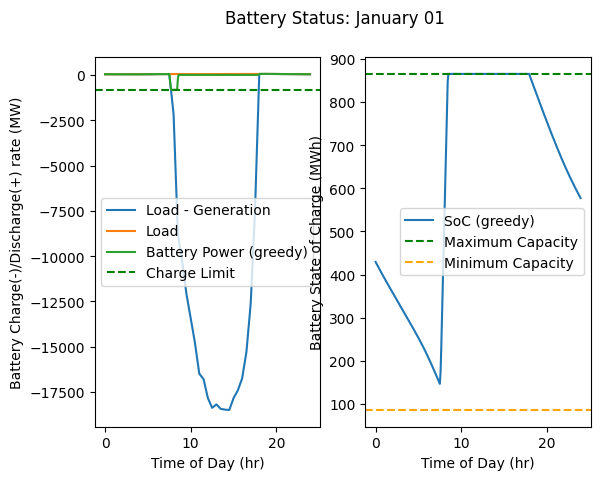

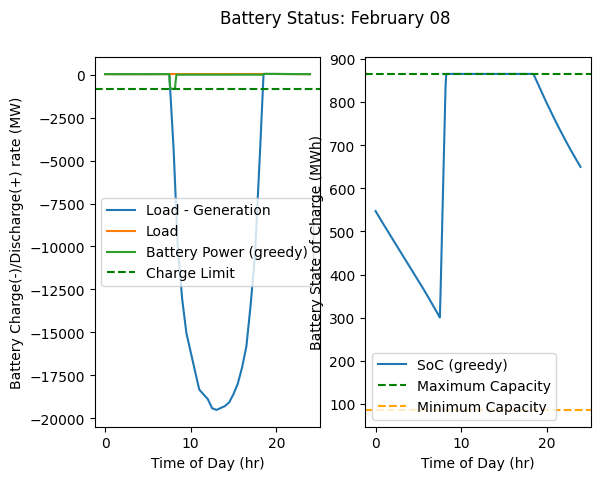

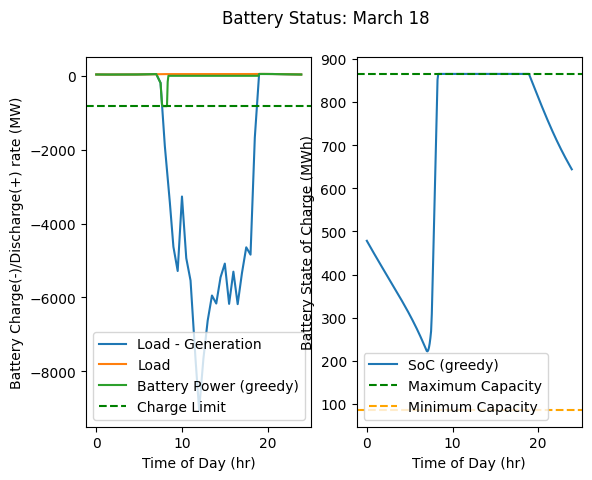

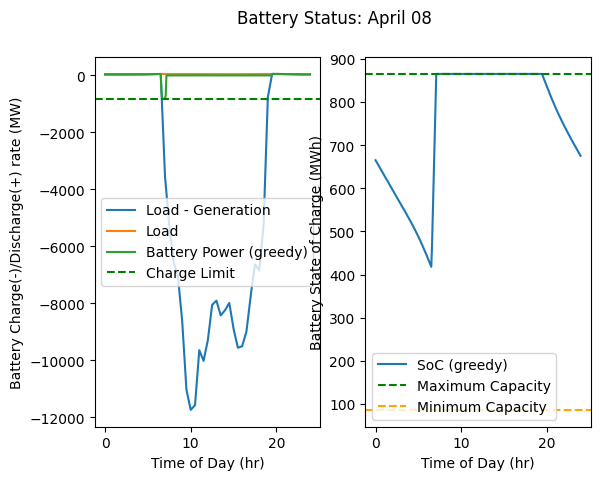

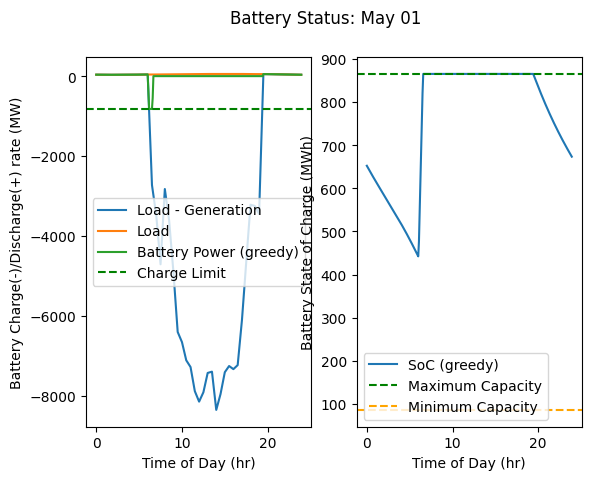

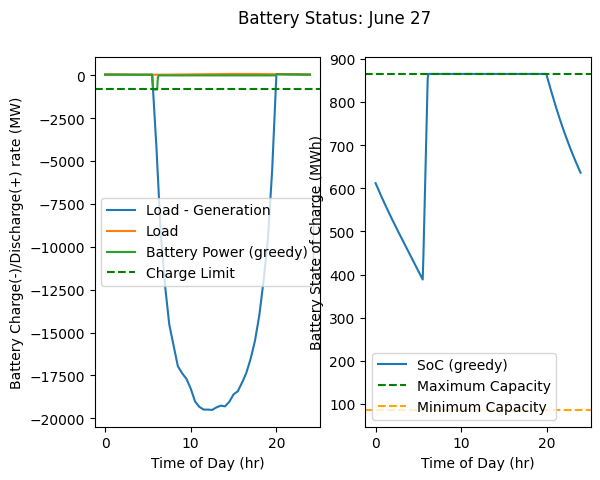

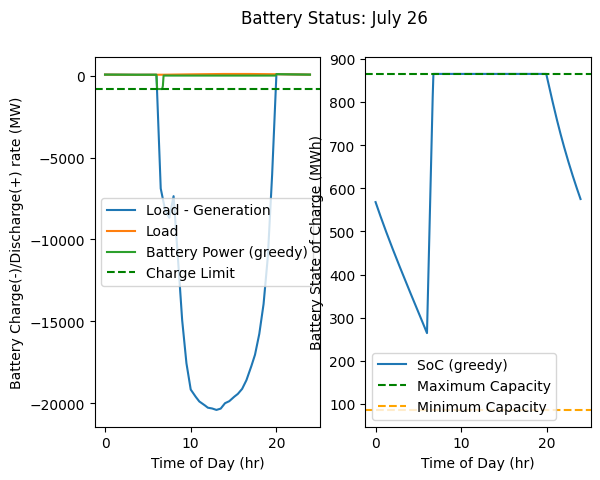

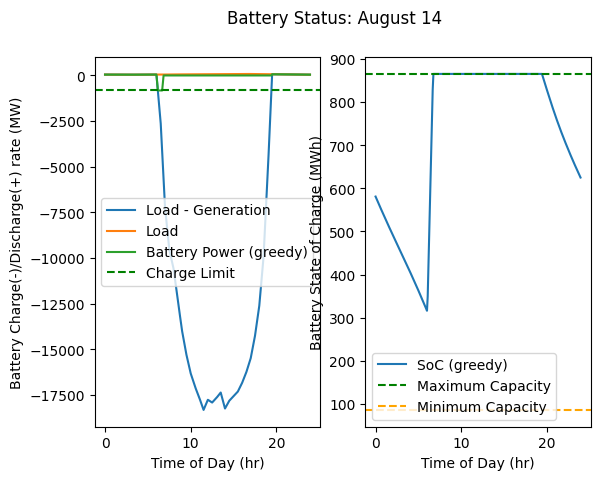

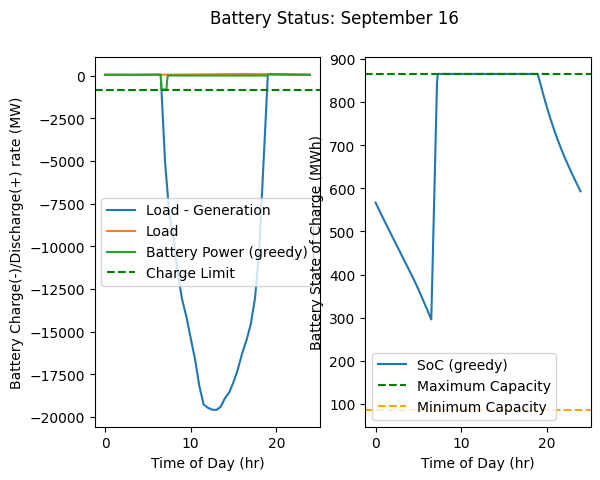

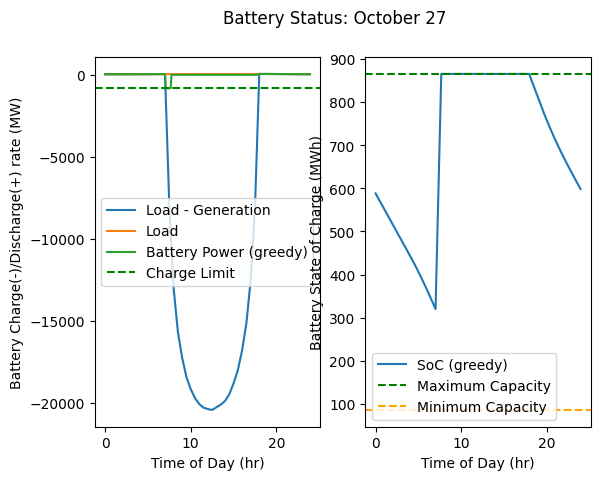

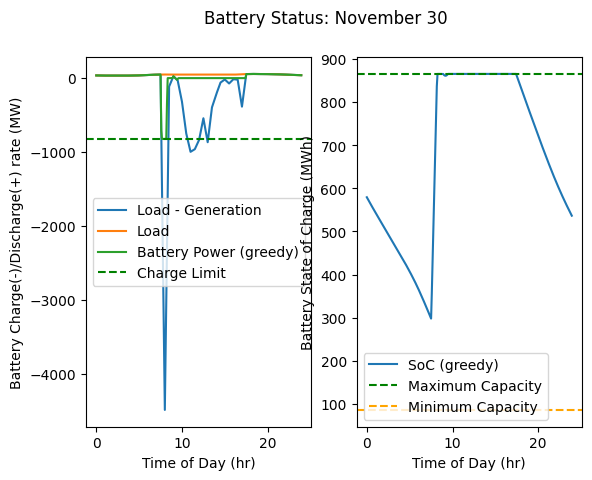

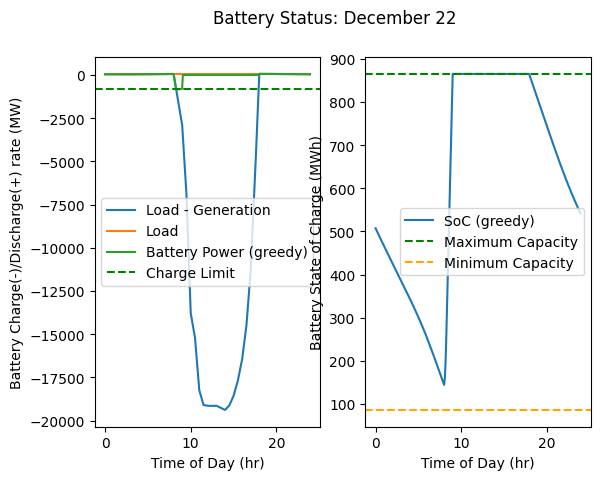

In [164]:
# def min_capacity_per_month(soc_over_year):
for month in range(1, 13):
    start, end = DAY_RANGES[month]
    # Day with minimum capacity
    day = start + np.argmin(
        # Minimum start across day
        np.min(soc_per_day[start:end], axis=1)
    )
    date = datetime.strftime(jan1 + dt_timedelta(days=int(day)), "%B %d")
    plot_battery_status(res, {
        "greedy": (u_batt_per_day[day], soc_per_day[day])
    }, time_one_day, load_per_day[day], generation_per_day[day], date)
    


In [99]:
def plot_battery_status(result, possible_controls, time, load, generation, title=None):
    fig, plots = plt.subplots(1, 2)
    
    title = f"Battery Status: {title}" if title is not None else "Battery Status"
    plt.suptitle(title)
    u_max, u_min = load, load - generation
    
    # Plot of battery power output
    plots[0].plot(time, u_min, label="Load - Generation")
    plots[0].plot(time, u_max, label="Load")
    max_u_batt = -np.inf
    for control_name, (u_batt, _) in possible_controls.items():
        plots[0].plot(time, u_batt, label=f"Battery Power ({control_name})")
        max_u_batt = max(max_u_batt, np.max(u_batt))
        
    plots[0].set_xlabel("Time of Day (hr)")
    plots[0].set_ylabel("Battery Charge(-)/Discharge(+) rate (MW)")
    
    # Max and min lines based on maximum power output.
    plots[0].axhline(y=-result.P_battery, linestyle="--", color='green', label="Charge Limit")
    if np.max(max_u_batt) > 0.5 * result.P_battery:
        plots[0].axhline(y=-result.P_battery, linestyle="--", color='orange', label="Discharge limit")
    plots[0].legend()
    
    for control_name, (_, soc) in possible_controls.items():
        plots[1].plot(time, soc, label=f"SoC ({control_name})")
    plots[1].set_xlabel("Time of Day (hr)")
    plots[1].set_ylabel("Battery State of Charge (MWh)")
    # Capacity lines
    plots[1].axhline(y=result.E_max, linestyle="--", color='green', label="Maximum Capacity")
    plots[1].axhline(y=result.model.rho * result.E_max, linestyle="--", color='orange', label="Minimum Capacity")
    plots[1].legend()
    

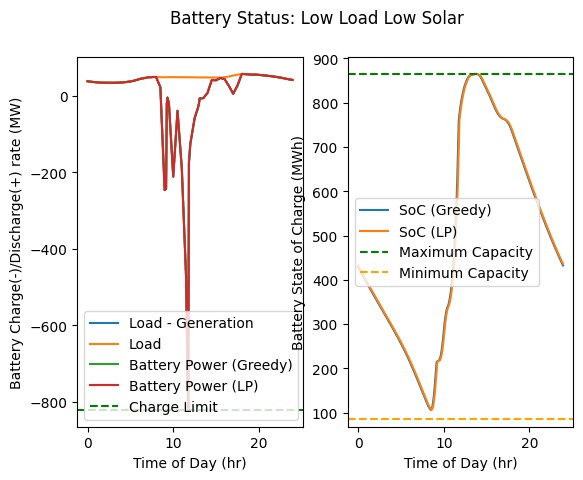

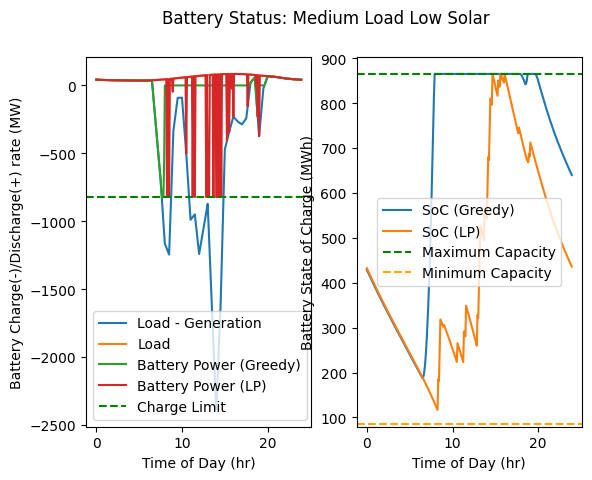

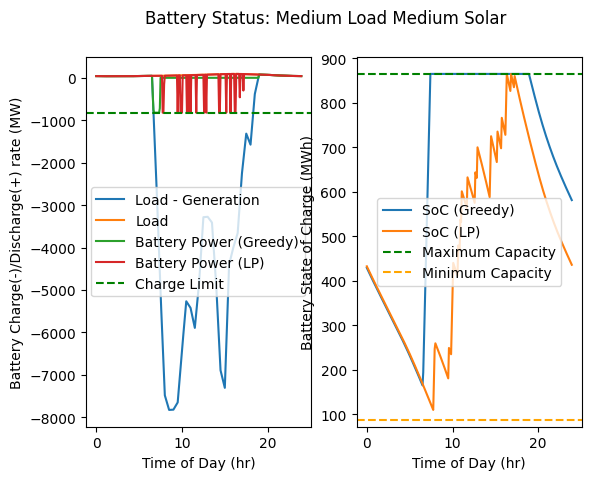

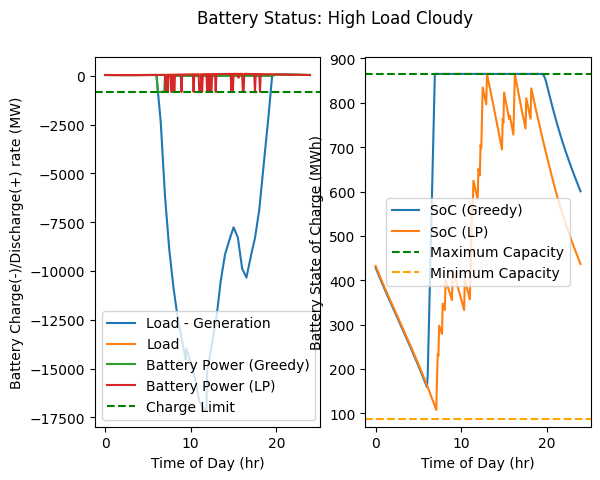

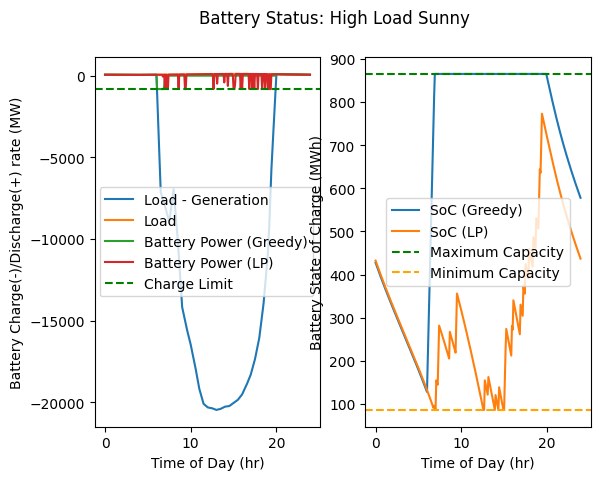

In [91]:
for scenario in res.scenarios:
    possible_controls = {}
    possible_controls["Greedy"] = greedy_battery_control(
        res, worst_load[scenario],
        worst_solar_pu[scenario] * res.P_solar)
    possible_controls["LP"] = (res.u_batt[scenario], res.x[scenario])
    generation = worst_solar_pu[scenario] * res.P_solar
    plot_battery_status(res, possible_controls, time_one_day, worst_load[scenario], generation)
                    
    


In [63]:
res.E_max / res.P_battery

1.0529862514653137

In [30]:
eta = 0.5
rho = 0.1
cost_battery = 100
cost_solar = 200
model = SinglePeriodModel(eta, rho, cost_battery, cost_solar)
res = model.minimize_cost(time_hr, load, solar_pu)
# res = minimize_system_cost(time, load, solar_pu, eta, rho, cost_battery, cost_solar)

In [31]:
res.result.x.shape

(1443,)

In [32]:
res.u_batt.shape

(1441,)

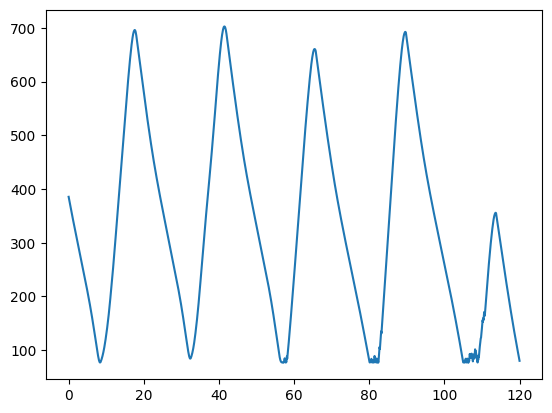

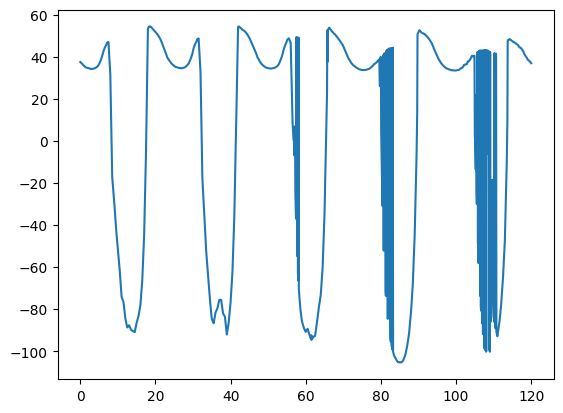

In [33]:
plt.figure()
plt.plot(time_hr, res.x)
plt.figure()
plt.plot(time_hr, res.u_batt)